In [78]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import numpy as np
import scanpy as sc
from util import normalize_rows, mse

from sklearn.utils.extmath import randomized_svd

# Concavity of sqrt

In [80]:
from scipy.special import factorial
def expected_sqrt(mean, samples=None):
    """Return expected square root of a poisson distribution. Expects ndarray input.
    
    If samples = None, uses Taylor series centered at 0 or mean, as appropriate.
    
    If samples = int, uses that many samples for an empirical distribution."""
    
    if samples is None:
    
        truncated_taylor_around_0 = np.zeros(mean.shape)
        nonzeros = (mean != 0)
        mean = mean + 1e-8
        small_values = mean*(mean < 4)
        for k in range(15):
            truncated_taylor_around_0 += small_values**k/factorial(k) * np.sqrt(k)
        truncated_taylor_around_0 *= np.exp(-small_values)

        truncated_taylor_around_mean = np.sqrt(mean) - np.sqrt(mean)**(-0.5)/8 + np.sqrt(mean)**(-1.5)/16

        expectation = nonzeros*(truncated_taylor_around_0 * (mean < 4) + truncated_taylor_around_mean * (mean >= 4))
        
    else:
        tot = np.zeros(mean.shape)
        for i in range(samples):
            tot += np.sqrt(np.random.poisson(mean))
        expectation = tot/samples
    return expectation

In [81]:
from scipy.special import factorial
def expected_log1p(mean, samples=None):
    """Return expected square root of a poisson distribution. Expects ndarray input.
    
    If samples = None, uses Taylor series centered at 0 or mean, as appropriate.
    
    If samples = int, uses that many samples for an empirical distribution."""
    
    if samples is None:
        raise NotImplementedError
    else:
        tot = np.zeros(mean.shape)
        for i in range(samples):
            tot += np.log1p(np.random.poisson(mean))
        expectation = tot/samples
    return expectation

In [5]:
mean = np.power(10.001, np.arange(-2, 2, 0.1))

In [6]:
e1 = expected_sqrt(mean)
e2 = expected_sqrt(mean, 1000)

In [7]:
np.corrcoef(e1.ravel(), e2.ravel())

array([[1.        , 0.99998645],
       [0.99998645, 1.        ]])

Text(0.5,1,'Sampling agrees with theory.')

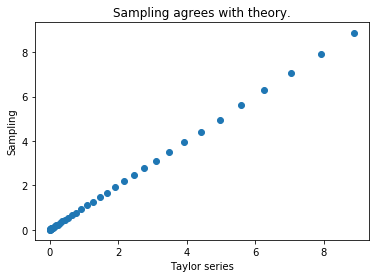

In [8]:
plt.scatter(e1, e2)
plt.xlabel("Taylor series")
plt.ylabel("Sampling")
plt.title("Sampling agrees with theory.")

Text(0.5,1,'Expectation is mean at low values')

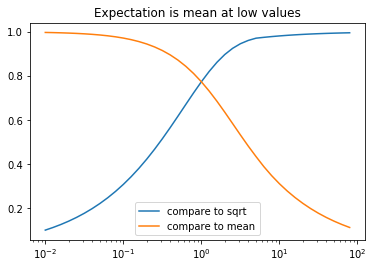

In [9]:
plt.plot(mean, expected_sqrt(mean)/np.sqrt(mean), label = 'compare to sqrt')
plt.plot(mean, expected_sqrt(mean)/mean, label = 'compare to mean')
plt.xscale('log')
plt.legend()
plt.title("Expectation is mean at low values")

# HCA

In [107]:
#hca = sc.read('/Users/josh/src/noise2self-single-cell/data/hca/hca_marrow_deep.h5ad')
hca = sc.read('/Users/josh/src/noise2self-single-cell/data/neurons/neurons_deep.h5ad')

hca_down = sc.pp.downsample_counts(hca, 3000, replace = False, copy = True)

In [130]:
hca.X.sum(axis = 1)

matrix([[23410.],
        [22998.],
        [34233.],
        ...,
        [33209.],
        [29824.],
        [29437.]], dtype=float32)

In [108]:
at_least_500 = np.array((hca.X.sum(axis = 0) > 500)).flatten()

In [110]:
x = np.array(hca_down.X.todense())

In [111]:
y = np.array(hca.X.todense())

In [112]:
y = y[:, at_least_500]
x = x[:, at_least_500]

In [113]:
mean = y/y.sum(axis = 1, keepdims = True) * 1000

In [114]:
z = expected_sqrt(mean)

In [115]:
x1 = np.random.binomial(x, 0.5)
x2 = x - x1

## PCA: Square root

In [116]:
x1_norm = np.sqrt(x1)
x2_norm = np.sqrt(x2)

U, S, V = randomized_svd(x1_norm, n_components=50, random_state=42)

ae_loss = []
ss_loss = []
gt_loss = []
k_range = np.arange(1, 30)
for k in k_range:
    x_pred = U[:,:k].dot(np.diag(S[:k])).dot(V[:k,:])
    ae_loss.append(mse(x_pred, x1_norm))
    ss_loss.append(mse(x_pred, x2_norm))
    gt_loss.append(mse(x_pred, z))
k_opt = k_range[np.argmin(ss_loss)]
                
print(k_opt)

18


Text(0.5,0,'Principal Components')

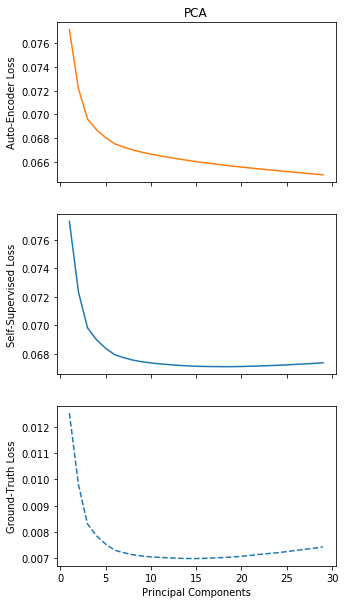

In [117]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

ax0.plot(k_range, ae_loss, color = 'C1')
ax0.set_title("PCA")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(k_range, ss_loss)
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(k_range, gt_loss, '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Principal Components')

In [118]:
# Negative log likelihood
def poisson_log_lik(lam, k, per_gene = False):
    if per_gene:
        return (lam - k*np.log(lam)).mean(axis = 0)
    else:
        return (lam - k*np.log(lam)).mean()

In [119]:
ss_loss, gt_loss, ae_loss = [], [], []
for k in np.arange(1, 10):
    x_pred = U[:,:k].dot(np.diag(S[:k])).dot(V[:k,:])
    ae_loss.append(poisson_log_lik(x_pred**2 + 1e-3, x1))
    ss_loss.append(poisson_log_lik(x_pred**2 + 1e-3, x2))
    gt_loss.append(poisson_log_lik(x_pred**2 + 1e-3, mean))

Text(0.5,0,'Principal Components')

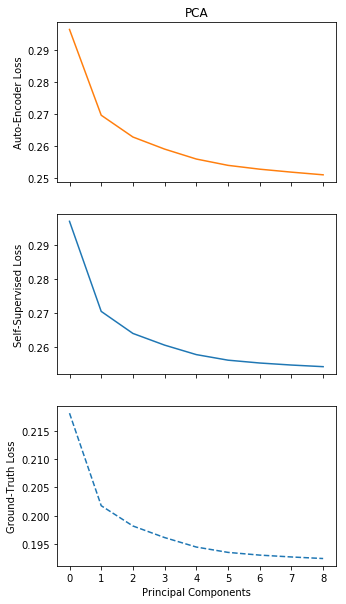

In [120]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

ax0.plot(ae_loss, color = 'C1')
ax0.set_title("PCA")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(ss_loss)
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(gt_loss, '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Principal Components')

If we use MSE loss on the counts, then the noise variance = variance(Poisson(lambda)) = lambda, which is also the mean. Thus the noise variance can be approximated as just the average of the input data, which would allow us to estimate the ground-truth reconstruction error.

# MAGIC

In [121]:
import magic
def compute_diff_op(x, lazy_p = 0):
    median_counts = np.median(x.sum(axis=1)) / 2

    X = np.sqrt(normalize_rows(x, median_counts))

    magic_op = magic.MAGIC()
    magic_op.fit(X)

    diff_op = np.array(magic_op.diff_op.todense())

    diff_op = (1 - lazy_p) * diff_op + lazy_p * np.eye(diff_op.shape[0])
    return diff_op

In [122]:
diff_op = compute_diff_op(x1, lazy_p = 0)

Running MAGIC on 4581 cells and 11238 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 9.31 seconds.
  Calculating KNN search...
  Calculated KNN search in 4.10 seconds.
  Calculating affinities...
  Calculated affinities in 5.47 seconds.
Calculated graph and diffusion operator in 19.12 seconds.


In [123]:
denoised = np.sqrt(x1)
ss_loss, gt_loss, ae_loss = [], [], []
max_t = 7

t_range = np.arange(max_t)

for t in t_range:
    ss_loss.append(mse(denoised, np.sqrt(x2)))
    ae_loss.append(mse(denoised, np.sqrt(x1)))
    gt_loss.append(mse(denoised, z))

    denoised = diff_op.dot(denoised)

Text(0.5,0,'Diffusion Time')

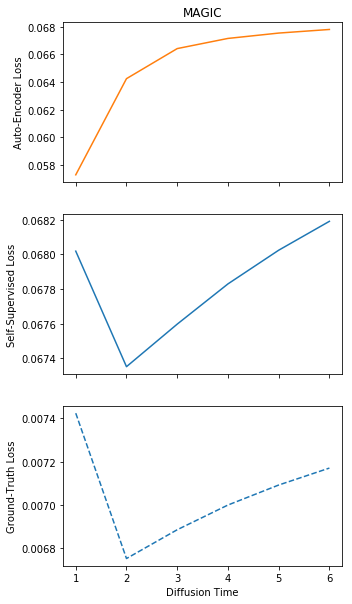

In [124]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

ax0.plot(t_range[1:], ae_loss[1:], color = 'C1')
ax0.set_title("MAGIC")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(t_range[1:], ss_loss[1:])
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(t_range[1:], gt_loss[1:], '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Diffusion Time')

MAGIC is too fast with initial parameters. We slow it down by making the walk lazy.

In [26]:
diff_op = compute_diff_op(x1, lazy_p = 0.5)

Running MAGIC on 1277 cells and 6883 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.09 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.25 seconds.
  Calculating affinities...
  Calculated affinities in 0.62 seconds.
Calculated graph and diffusion operator in 2.00 seconds.


In [27]:
denoised = np.sqrt(x1)
ss_loss, gt_loss, ae_loss = [], [], []
max_t = 7

t_range = np.arange(max_t)

for t in t_range:
    ss_loss.append(mse(denoised, np.sqrt(x2)))
    ae_loss.append(mse(denoised, np.sqrt(x1)))
    gt_loss.append(mse(denoised, z))

    denoised = diff_op.dot(denoised)

Text(0.5,0,'Diffusion Time')

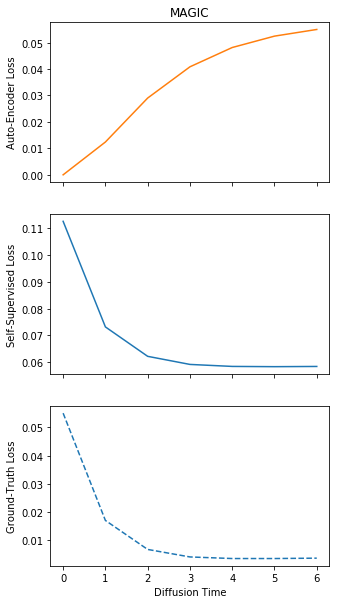

In [28]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

ax0.plot(t_range, ae_loss, color = 'C1')
ax0.set_title("MAGIC")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(t_range, ss_loss)
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(t_range, gt_loss, '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Diffusion Time')

In [29]:
print("Min GT Loss: ", np.min(gt_loss))

Min GT Loss:  0.003460921099927307


## Poisson

We can also use a Poisson loss on averaged counts.

In [30]:
denoised = x1.copy()

ss_loss, gt_loss, ae_loss = [], [], []

for i in range(max_t):    
    ae_loss.append(poisson_log_lik(denoised + 1e-3, x1))
    ss_loss.append(poisson_log_lik(denoised + 1e-3, x2))
    gt_loss.append(poisson_log_lik(denoised + 1e-3, mean))

    denoised = diff_op.dot(denoised)

Text(0.5,0,'Diffusion Time')

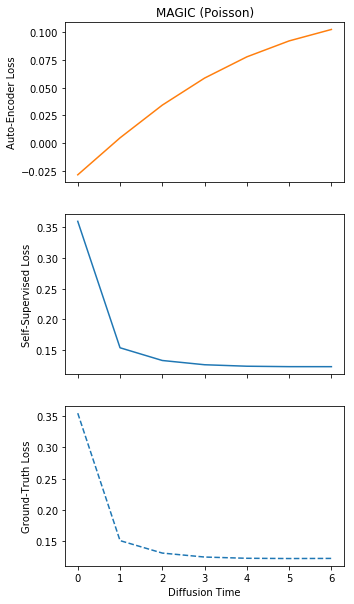

In [31]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

ax0.plot(ae_loss, color = 'C1')
ax0.set_title("MAGIC (Poisson)")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(ss_loss)
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(gt_loss, '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Diffusion Time')

## Per gene diffusion times

In [32]:
diff_op = compute_diff_op(x1, 0.5)

Running MAGIC on 1277 cells and 6883 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.06 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.25 seconds.
  Calculating affinities...
  Calculated affinities in 0.50 seconds.
Calculated graph and diffusion operator in 1.86 seconds.


In [33]:
denoised = np.sqrt(x1)
best_denoised = np.sqrt(x1)
ss_loss, gt_loss, ae_loss = [], [], []

ss_losses = np.zeros((max_t, x1.shape[1]))
gt_losses = np.zeros((max_t, x1.shape[1]))
ae_losses = np.zeros((max_t, x1.shape[1]))

t_range = np.arange(max_t)

for t in t_range:
    ae_losses[t] = ((denoised - np.sqrt(x1))**2).mean(axis = 0)
    ss_losses[t] = ((denoised - np.sqrt(x2))**2).mean(axis = 0)
    gt_losses[t] = ((denoised - z)**2).mean(axis = 0)

    new_best_idx = (np.min(ss_losses[:(t+1)], axis=0) == ss_losses[t])
    best_denoised[:, new_best_idx] = denoised[:, new_best_idx]

    denoised = diff_op.dot(denoised)

best_t = np.argmin(ss_losses, axis=0)

In [34]:
best_t_sqrt = best_t

In [35]:
best_ae_loss = ((best_denoised - np.sqrt(x1))**2).mean()
best_ss_loss = ((best_denoised - np.sqrt(x2))**2).mean()
best_gt_loss = ((best_denoised - z)**2).mean()
np.isclose(best_gt_loss, gt_losses[best_t, np.arange(len(best_t))].mean())

True

In [36]:
np.min(gt_losses.mean(axis = 1)), best_gt_loss

(0.003461620168074409, 0.002643969523743522)

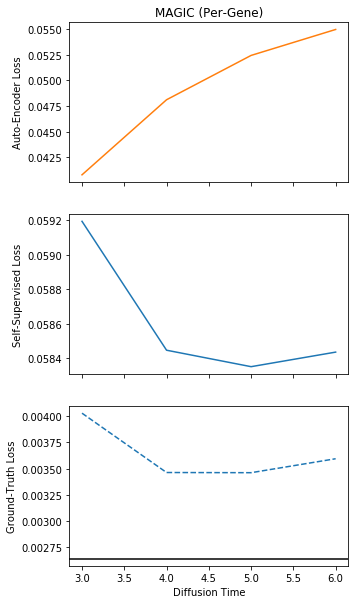

In [37]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

start_idx = 3

ax0.plot(t_range[start_idx:], ae_losses.mean(axis = 1)[start_idx:], color = 'C1')
ax0.set_title("MAGIC (Per-Gene)")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(t_range[start_idx:], ss_losses.mean(axis = 1)[start_idx:])
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(t_range[start_idx:], gt_losses.mean(axis = 1)[start_idx:], '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Diffusion Time')
ax2.axhline(best_gt_loss, color = 'black')

(array([  12.,   13.,    0.,   22.,    0.,  104.,  316.,    0.,  609.,
        5807.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

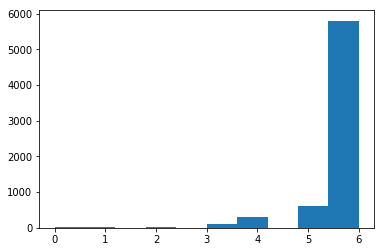

In [38]:
plt.hist(best_t_sqrt)

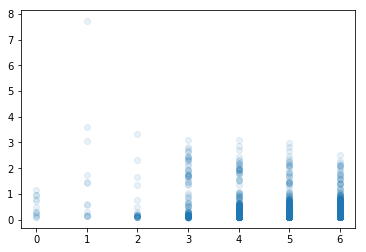

In [39]:
plt.scatter(best_t_sqrt, np.sqrt(mean.mean(axis = 0)), alpha = 0.1)

# Per-Gene Poisson

In [40]:
import magic
lazy_p=0.5

median_counts = np.median(x1.sum(axis=1)) / 2

X1 = np.sqrt(normalize_rows(x1, median_counts))
X2 = np.sqrt(normalize_rows(x2, median_counts))

magic_op = magic.MAGIC()
magic_op.fit(X1)

diff_op = np.array(magic_op.diff_op.todense())

diff_op = lazy_p * diff_op + (1 - lazy_p) * np.eye(diff_op.shape[0])

Running MAGIC on 1277 cells and 6883 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.15 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.26 seconds.
  Calculating affinities...
  Calculated affinities in 0.52 seconds.
Calculated graph and diffusion operator in 1.98 seconds.


In [41]:
denoised = x1.copy().astype(np.float)
best_denoised = x1.copy().astype(np.float)
max_t = 20

ss_losses = np.zeros((max_t, x1.shape[1]))
gt_losses = np.zeros((max_t, x1.shape[1]))
ae_losses = np.zeros((max_t, x1.shape[1]))

t_range = np.arange(max_t)

for t in t_range:
    ae_losses[t] = poisson_log_lik(denoised + 1e-3, x1, per_gene=True)
    ss_losses[t] = poisson_log_lik(denoised + 1e-3, x2, per_gene=True)
    gt_losses[t] = poisson_log_lik(denoised + 1e-3, mean, per_gene=True)
    new_best_idx = (np.argmin(ss_losses[:(t+1)], axis=0) == t)
    
    best_denoised[:, new_best_idx] = denoised[:, new_best_idx]
    denoised = diff_op.dot(denoised)

best_t = np.argmin(ss_losses, axis=0)

In [42]:
best_t_poisson = best_t

In [43]:
best_ae_loss = poisson_log_lik(best_denoised + 1e-3, x1)
best_ss_loss = poisson_log_lik(best_denoised + 1e-3, x2)
best_gt_loss = poisson_log_lik(best_denoised + 1e-3, mean)
np.isclose(best_gt_loss, gt_losses[best_t, np.arange(len(best_t))].mean())

True

In [44]:
np.min(gt_losses.mean(axis = 1)), best_gt_loss

(0.12287649599018671, 0.1196187987848473)

In [45]:
print("Best possible: ", poisson_log_lik(mean + 1e-3, mean))

Best possible:  0.10370534


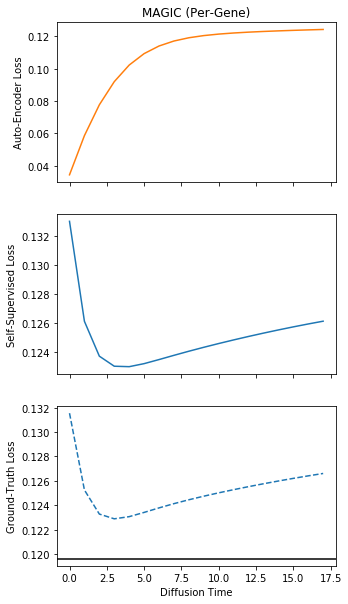

In [46]:
f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

ax0.plot(ae_losses[2:].mean(axis = 1), color = 'C1')
ax0.set_title("MAGIC (Per-Gene)")
ax0.set_ylabel('Auto-Encoder Loss')

ax1.plot(ss_losses[2:].mean(axis = 1))
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(gt_losses[2:].mean(axis = 1), '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Diffusion Time')
ax2.axhline(best_gt_loss, color = 'black')

(array([  31.,  134.,  868., 1180.,  740.,  494.,  328.,  226.,  157.,
        2725.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

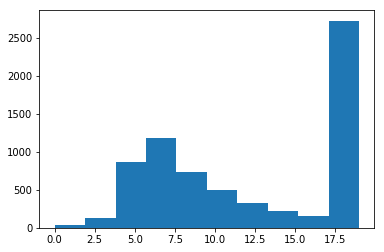

In [47]:
plt.hist(best_t_poisson)

In [48]:
big_expr = (mean.mean(axis = 0) > 0.11)
np.corrcoef(best_t_sqrt[big_expr], best_t_poisson[big_expr])

array([[1.       , 0.5174704],
       [0.5174704, 1.       ]])

(array([[  6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  1.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  40.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  11.,  96.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0., 133.,  28.,   0.,   0.,   0.,   0.,   0.,   4.],
        [  0.,   0.,  43., 284., 130.,  78.,  37.,  21.,  17., 180.]]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <matplotlib.image.AxesImage at 0x1264faf28>)

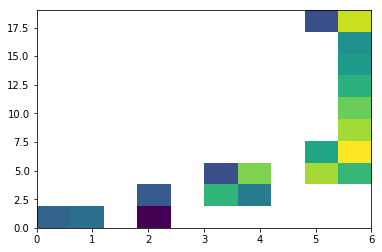

In [49]:
import matplotlib as mpl
plt.hist2d(best_t_sqrt[big_expr], best_t_poisson[big_expr], norm=mpl.colors.LogNorm())

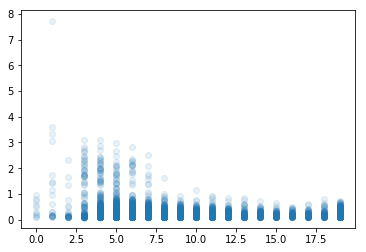

In [50]:
plt.scatter(best_t_poisson, np.sqrt(mean.mean(axis = 0)), alpha = 0.1)

# Figure 2: Effect of Denoising

Analysis of this dataset: https://www.exphem.org/article/S0301-472X(18)30805-1/fulltext#sec0002

In [51]:
data = hca

In [52]:
hca.var_names[hca.var_names.str.startswith('PU')]

Index(['PUSL1', 'PUM1', 'PUM2', 'PUS10', 'PURA', 'PURB', 'PUS7', 'PUDP',
       'PUF60', 'PUM3', 'PUS3', 'PUS7L', 'PUS1'],
      dtype='object', name='index')

(array([482., 269., 221., 168.,  79.,  34.,  14.,   6.,   2.,   2.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ],
       dtype=float32),
 <a list of 10 Patch objects>)

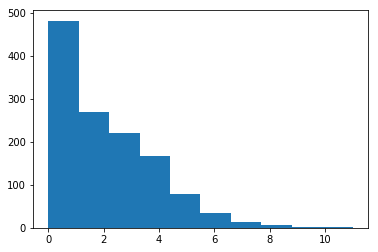

In [53]:
plt.hist(data[:,'PUS1'].X)

In [54]:
data = hca_down
data = hca

In [55]:
np.corrcoef(hca_down[:,'GATA1'].X, 
            hca_down[:,'KLF1'].X)[0,1], \
np.corrcoef(hca[:,'GATA1'].X, hca[:,'KLF1'].X)[0,1]

(0.030803019787081474, 0.2480626872080457)

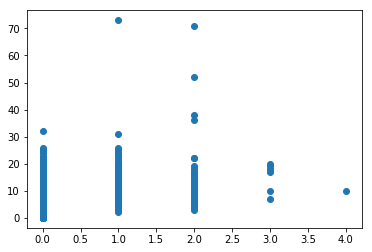

In [56]:
plt.scatter(hca_down[:,'GATA1'].X, hca[:, 'GATA1'].X)

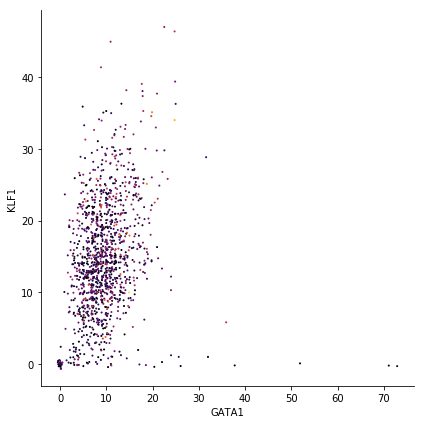

In [57]:
jitter = True

data = hca 

if jitter:
    mol = data.X.sum(axis = 1).mean()
    j1 = np.random.randn(data.X.shape[0])/4
    j2 = np.random.randn(data.X.shape[0])/4
else:
    j1 = np.zeros(data.X.shape[0])
    j2 = j1

plt.figure(figsize=(6,6))

plt.scatter(data[:,'GATA1'].X + j1, data[:,'KLF1'].X + j2, 
            c = data[:,'PUS1'].X ,cmap='inferno', s=1)

plt.xlabel('GATA1')
plt.ylabel('KLF1')
# plt.yticks([])
# plt.xticks([])

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)

plt.tight_layout()

# plt.savefig(dir + 'raw_data_noaxis.png')

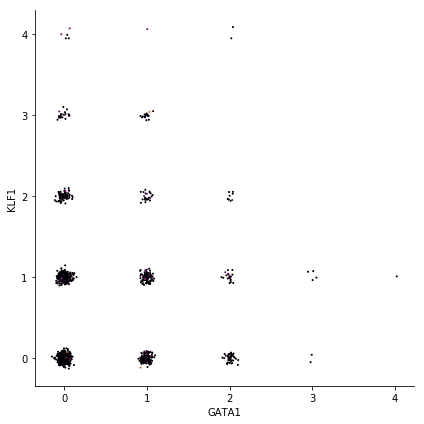

In [58]:
jitter = True

data = hca_down

if jitter:
    mol = data.X.sum(axis = 1).mean()
    j1 = np.random.randn(data.X.shape[0])/25
    j2 = np.random.randn(data.X.shape[0])/25
else:
    j1 = np.zeros(data.X.shape[0])
    j2 = j1

plt.figure(figsize=(6,6))

plt.scatter(data[:,'GATA1'].X + j1, data[:,'KLF1'].X + j2, 
            c = data[:,'PUS1'].X ,cmap='inferno', s=1)

plt.xlabel('GATA1')
plt.ylabel('KLF1')
# plt.yticks([])
# plt.xticks([])

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['bottom'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)

plt.tight_layout()

# plt.savefig(dir + 'raw_data_noaxis.png')

# Poisson Matrix Factorization

In [59]:
from scipy.sparse import issparse
def cor(X, Y):
    if issparse(X):
        X = np.array(X.todense())
    if issparse(Y):
        Y = np.array(Y.todense())
    return np.corrcoef(X.ravel(), Y.ravel())[0, 1]

In [60]:
print("Original correlation: ", cor(hca_down.X.sqrt(), hca.X.sqrt()))

Original correlation:  0.7802032108454697


In [61]:
print("Denoised correlation: ", cor(np.sqrt(denoised_hca.X), hca.X.sqrt()))

NameError: name 'denoised_hca' is not defined

In [ ]:
print("Denoised correlation: ", cor(np.sqrt(denoised_hca_pca.X), hca.X.sqrt()))

In [ ]:
from util import poisson_expected_sqrt
expected_sqrt = poisson_expected_sqrt(np.array(hca.X.todense())/np.array(hca.X.todense()).sum(axis = 1, keepdims = True)*2000, 30)

# Simulation

In [ ]:
import pickle
with open('/Users/josh/src/noise2self-single-cell/data/sim/dataset_0.pickle', 'rb') as fp:
    exp, class_labels, programs, lib_size, umis_X, umis_Y = pickle.load(fp)

In [ ]:
true_means = np.exp(exp.dot(programs))

In [ ]:
model = LowRank()
best_rank, rank_range, losses = model.sweep(umis_X, umis_Y, 30)

In [ ]:
plt.plot(rank_range, losses)
plt.xlabel("Rank")
plt.ylabel("Self-Supervised Loss")
plt.title("Sweep Rank")
plt.axvline(best_rank, color="k", linestyle="--")

denoised = model.fit_transform(umis_X, umis_Y)

In [ ]:
umis_X = paul.X

In [ ]:
from sklearn.utils.extmath import randomized_svd

U, S, V = randomized_svd(np.sqrt(umis_X), 9)

In [ ]:
plt.plot(S)

In [ ]:
plt.plot((S*S).cumsum()/umis_X.sum())
plt.ylim(0,1)

In [ ]:
denoised_sqrt = U.dot(np.diag(S)).dot(V)

In [ ]:
denoised_sqrt = np.maximum(denoised_sqrt, 0)

In [ ]:
correlation(denoised_sqrt.ravel(), np.sqrt(true_means).ravel())

In [ ]:
(denoised_sqrt*denoised_sqrt).sum(1)

In [ ]:
(denoised_sqrt*denoised_sqrt).sum(1)

In [ ]:
umis_X.sum(1)

In [ ]:
from scipy.spatial.distance import correlation

In [ ]:
(denoised*denoised).sum(), umis_X.sum()

In [ ]:
correlation(np.sqrt(denoised).ravel(), np.sqrt(true_means).ravel())

In [ ]:
correlation(np.sqrt(umis_X).ravel(), np.sqrt(true_means).ravel())

In [ ]:
adata = sc.AnnData(X = umis_X)

In [ ]:
adata = 

# Stability of PC Regression

In [ ]:
paul = sc.datasets.paul15()

In [ ]:
denoised_adata = n2s_low_rank(paul, regression=True)

In [ ]:
V = np.random.randn(500,5)
W = np.random.randn(5, 200)
L = (V.dot(W))
L = L/(np.max(L))*3

X1 = np.random.randn(V)
X2 = np.random.randn(W)

In [ ]:
X = paul.X

X = X.astype(np.int)
np.random.seed(0)
X1 = np.random.binomial(X, 0.5)
X2 = X - X1

In [ ]:
x = np.sqrt(denoised_adata.X)

In [ ]:
rank_range = np.arange(1, 25, 2)
diff_from_opt = np.zeros(len(rank_range))
for i, r in enumerate(rank_range):
    model = LowRank(r, regression=True)
    y = model.fit_transform(X1, X2)
    diff = ((np.sqrt(y) - x)**2).mean()
    diff_from_opt[i] = diff
    print(r, ': ', diff)

In [ ]:
plt.plot(rank_range, diff_from_opt)
plt.xlabel("Rank")
plt.ylabel("Distance from opt")
plt.title("Overshooting PC rank barely impacts output")
plt.axvline(rank_range[np.argmin(diff_from_opt)], color='k', linestyle='--')

# Coefficients 

Given a matrix X which we write as $U S V$ and approximate as $U_r S_r V_r$, we may consider the PC regression to $Y$. That is,
we try to predict $Y$ from the feature matrix $X V_r^t S_r^{-1}= U_r$.

The regression map $W: \mathbb{R}^r \rightarrow \mathbb{R}^n$ is given by 

$W = U_r^t Y,$

since the feature matrix is orthogonal.

The weights for the $k^{th}$ PC are given by the $k^{th}$ row of that matrix. In particular, they do not depend on the choice of rank $r > k$.

(Note: there are two ways to view this. We may project the data $X$ orthogonally into PC space (in which case higher PCs will have low weight), or we may take it's coordinates in PC space (in which case all PCs will have equal weight). We choose the latter, since it shows that for the PCs with noisy values very little gets used. This is equivalent to dividing by $S_r$ after projection, which just shifts that term from $W$ over to the feature matrix.)

In [ ]:
from scipy.sparse import issparse

X = paul.X
#X = hca_down.X

if issparse(X):
    X = np.array(X.todense())

X = X.astype(np.int)

np.random.seed(0)
X1 = np.random.binomial(X, 0.5)
X2 = X - X1

X1 = np.sqrt(X1)
X2 = np.sqrt(X2)

In [ ]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(X1, n_components=100, random_state=42)

In [ ]:
W_pcr = U.T.dot(X2)
weight_norm_pcr = (W_pcr*W_pcr).sum(axis = 1)

W_pca = U.T.dot(X1)
weight_norm_pca = (W_pca*W_pca).sum(axis = 1)

The total norm of such coefficients is 1 if we use $X$ to regress $X$. When we are predicting $Y$, then the 
coefficients may drop off.

In [ ]:
plt.plot(weight_norm_pcr, label = "PCR")
plt.plot(weight_norm_pca, label = "PCA")
plt.title("PC Regression has smaller coeffs on later PCs than PCA")
plt.xlabel("Principal Component")
plt.ylabel("Coefficient in Regression")
plt.yscale("log")
plt.legend()